In [ ]:
!pip install mecab-python3 unidic-lite matplotlib numpy matplotlib-fontja pandas scipy==1.12 gensim

# 単語分析

#### single book test

In [ ]:
import MeCab

path = "./dataset/akutagawa/ababababa.txt"

def read_file(path):
    f = open(path, encoding="shift_jis")
    return f.read()

tagger = MeCab.Tagger()

text = read_file(path)

word_count = {}

node = tagger.parseToNode(text)

while node:
    word = node.surface
    if word in word_count.keys():
        count = word_count[word]
        word_count[word] = count + 1
    else:
        word_count[word] = 1
    node = node.next
    
word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
print(word_count)

#### single author test

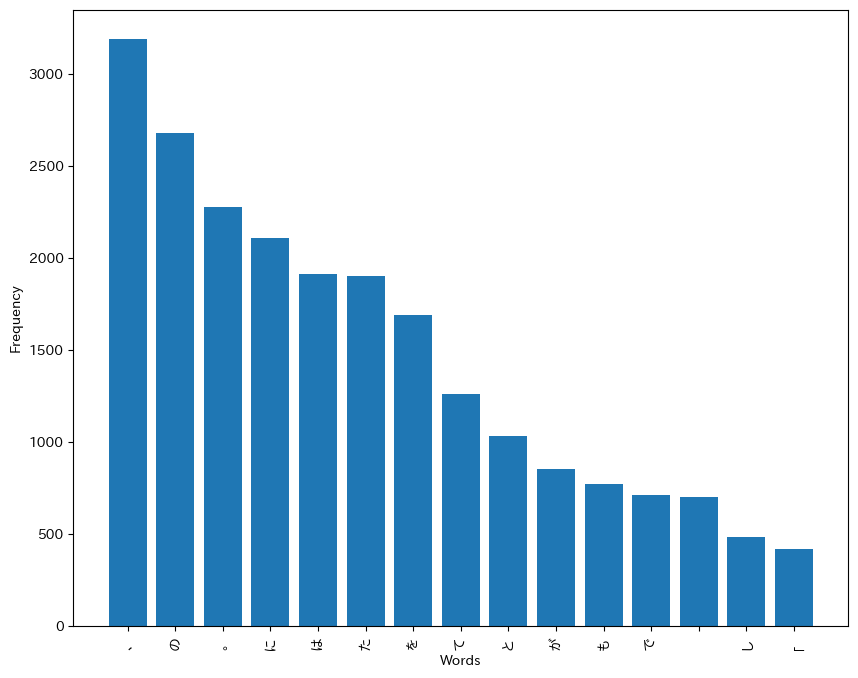

In [9]:
import os
import MeCab
import matplotlib.pyplot as plt

author_path = "./dataset/akutagawa"
word_count = {}

def scan_file(path) -> list[str]:
    try:
        with os.scandir(path) as entries:
            items = [entry.name for entry in entries if entry.is_file()]
        return items
    except Exception as e:
        print(e)


def read_file(path):
    f = open(path, encoding="shift_jis")
    return f.read()

tagger = MeCab.Tagger()


files = scan_file(author_path)
for i, file in enumerate(files):
    text = read_file(f'{author_path}/{file}')

    node = tagger.parseToNode(text)

    while node:
        word = node.surface
        if word in word_count.keys():
            count = word_count[word]
            word_count[word] = count + 1
        else:
            word_count[word] = 1
        node = node.next
    
word_list = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
# print(word_list)

author_count = [item[1] for item in word_list]

words = [item[0] for item in word_list[:15]]  # Top 30 words
counts = [item[1] for item in word_list[:15]]

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

## bast author word

In [ ]:
import os
import MeCab

folder_path = "./dataset"
author_word_count = {}

def scan_file(path) -> list[str]:
    try:
        with os.scandir(path) as entries:
            items = [entry.name for entry in entries if entry.is_file()]
        return items
    except Exception as e:
        print(e)
        
def scan_folder(path) -> list[str]:
    try:
        with os.scandir(path) as entries:
            items = [entry.name for entry in entries]
        return items
    except Exception as e:
        print(e)


def read_file(path):
    f = open(path, encoding="shift_jis")
    return f.read()

tagger = MeCab.Tagger()

author_dict = {'akutagawa': [], 'mori': [], 'dazai': [], 'natume': [], 'nakajima': [],}
line_dict = []

folders = scan_folder(folder_path)
for i, folder in enumerate(folders):
    if folder == 'pre':
        continue
    word_count = {}
    files = scan_file(f'{folder_path}/{folder}')
    for file in files:
        text = read_file(f'{folder_path}/{folder}/{file}')

        node = tagger.parseToNode(text)

        while node:
            word = node.surface
            if word in word_count.keys():
                count = word_count[word]
                word_count[word] = count + 1
            else:
                word_count[word] = 1
            line_dict.append(word)
            if word == '。':
                author_dict[folder].append(line_dict)
                line_dict = []
            
            node = node.next
    word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
    author_word_count[folder] = word_count

print(author_word_count)

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib_fontja
import pandas as pd

n = None
r = 0

akutagawa_list = [item[0] for item in author_word_count['akutagawa'][:n]]
dazai_list = [item[0] for item in author_word_count['dazai'][:n]]
mori_list = [item[0] for item in author_word_count['mori'][:n]]
natume_list = [item[0] for item in author_word_count['natume'][:n]]
nakajima_list = [item[0] for item in author_word_count['nakajima'][:n]]


# 統合リストを作成し、重複を無視
labels = list(set(akutagawa_list + dazai_list + mori_list + natume_list + nakajima_list))

# 各作家のデータを整形
akutagawa_counts = [dict(author_word_count['akutagawa'][:n]).get(label, 0) for label in labels]
dazai_counts = [dict(author_word_count['dazai'][:n]).get(label, 0) for label in labels]
mori_counts = [dict(author_word_count['mori'][:n]).get(label, 0) for label in labels]
natume_counts = [dict(author_word_count['natume'][:n]).get(label, 0) for label in labels]
nakajima_counts = [dict(author_word_count['nakajima'][:n]).get(label, 0) for label in labels]

total_counts = [(akutagawa_counts[i] + dazai_counts[i] + mori_counts[i] + natume_counts[i] + nakajima_counts[i]) for i, label in enumerate(labels)]

# ラベルごとに値をまとめる
combined = list(zip(total_counts, labels, akutagawa_counts, dazai_counts, mori_counts, natume_counts, nakajima_counts))

# 目的のリストに従ってソート
sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)  # ここではtotal_countをキーにソート

# ソート後に分解
total_counts, labels, akutagawa_counts, dazai_counts, mori_counts, natume_counts, nakajima_counts = zip(*sorted_combined)

stop_df = pd.DataFrame.from_dict(dict(label = labels[:int(len(labels) * r)], count = total_counts[:int(len(total_counts) * r)]))
oringin_word_df = pd.DataFrame.from_dict(dict(label = labels[int(len(labels) * r):], count = total_counts[int(len(total_counts) * r):]))
stop_df.to_csv(f'./output/stopword_n_{n}.csv')
print("word count:", len(labels), f"remove {r}:", int(len(labels) * r))
print(stop_df)


oringin_word_df.to_csv(f'./output/origin_n_{n}.csv')
print("word count:", len(labels), f"remove {r}:", len(labels) - int(len(labels) * r))
print(oringin_word_df)

labels_plot = [f'{a} {b}' for a, b in zip(labels, total_counts)]

if n != None and len(labels_plot) <= 10:
    # グラフを描画
    x = np.arange(len(labels_plot))  # ラベルの位置
    width = 0.2  # バーの幅

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, akutagawa_counts, width, label='Akutagawa')
    bars2 = ax.bar(x, dazai_counts, width, label='dazai')
    bars3 = ax.bar(x + width, mori_counts, width, label='Mori')

    # ラベルを追加
    ax.set_xlabel('Characters')
    ax.set_ylabel('Counts')
    ax.set_title('Character Counts by Author')
    ax.set_xticks(x)
    ax.set_xticklabels(labels_plot)
    ax.legend()

    # バーのラベルを表示
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # バーの上に少しずらして表示
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)

    plt.show()


word count: 19984 remove 0: 0
Empty DataFrame
Columns: [label, count]
Index: []
word count: 19984 remove 0: 19984
           label  count
0              、  18252
1              の  14898
2              。  11888
3              に  11707
4              て  10549
...          ...    ...
19979  Nietzsche      1
19980         掘立      1
19981         余れ      1
19982        ふくめ      1
19983         調理      1

[19984 rows x 2 columns]
